
### Spectroscopic Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2024  

In [1]:
import sys
# Add the parent directory to the system path
sys.path.insert(1, r"C:\Users\sk88\Documents\python_scripts")

import Function_files.data_functions as dat
from Function_files.filter_functions import smooth_data
from Function_files.math_functions import bin_data, OD_calc
from Function_files.plotting_class import Spectra_Plotter
import Spectroscopy.PrYSO.config_files._3P0 as config_file

import os
plt = Spectra_Plotter()

In [2]:
import numpy as np

def loadnumpy(fname, delimiter=';'):
    data = np.loadtxt(fname=fname, delimiter=delimiter)
    return np.array([data[0], data[1]])

In [3]:
# import config file dictionary
dir = os.path.join(config_file.root, config_file.file)
# interogate directory to extract folder and file names
folder_list, file_list = dat.dir_interrogate(path=dir, extensions=config_file.extensions, exceptions=config_file.exceptions)
# create dictionary for indexing folders and files
fol_i = dat.make_index_dict(folder_list)
fil_i = [dat.make_index_dict(file_sub_list) for file_sub_list in file_list]
# assemble reference paths
ref_paths = dat.search_paths(folder_list, file_list, include=config_file.refs)
ref_path_list = [os.path.join(dir, x) for x in ref_paths]
# assemble spectra paths
spectra_paths = dat.search_paths(folder_list, file_list, exclude=config_file.refs)
if config_file.single:
    spectra_path_list = [os.path.join(dir, x) for x in spectra_paths]
else:
    spectra_path_list = [os.path.join(dir, x) for files in spectra_paths for x in files]
# extract data from the folders
if config_file.numpy:
    ref_data_1 = [loadnumpy(x, delimiter=';') for x in ref_path_list if "SAV" in x]
    spectra_data_1 = [loadnumpy(x,delimiter=';') for x in spectra_path_list if "SAV" in x]
    ref_data_2 = [loadnumpy(x, delimiter=';') for x in ref_path_list if "FAV" in x]
    spectra_data_2 = [loadnumpy(x,delimiter=';') for x in spectra_path_list if "FAV" in x]

    ref_data =  [ref_data_1, ref_data_2]
    spectra_data = [spectra_data_1, spectra_data_2]
else:
    ref_metadata, ref_data = dat.spectrum_extract(ref_path_list, keys=config_file.polarisations)
    spectra_metadata, spectra_data = dat.spectrum_extract(spectra_path_list, keys=config_file.polarisations)
spectra_waves, spectra_intensities = dat.seperate_lists(spectra_data) 
reference_waves, reference_intensities = dat.seperate_lists(ref_data)

In [4]:
# calculate OD and correct for power variance
OD_sets = [[OD_calc(ref_data=ref[0], trans_data=spectra, c_factor=config_file.correction) for spectra in spectra_set] for ref, spectra_set in zip(reference_intensities, spectra_intensities)]
# subtract mean value to compensate for background
zeroed_OD = [[values - bin_data(values, 100) for values in spectra] for spectra in OD_sets]
# create subtracted set (minus lowest temp data)
subtracted_OD = [[values - spectra[0] for values in spectra] for spectra in zeroed_OD]
# create smoothed sets using boxcar
smoothed = [[smooth_data(values, N=10) for values in spectra] for spectra in zeroed_OD]
# calibrate for OSA and convert wavelengths to wavenumbers 
shifted_waves = [[values + config_file.calibration for values in wavelengths] for wavelengths in spectra_waves]
wavevector_sets = [[1E7 / values for values in wavelengths] for wavelengths in shifted_waves]

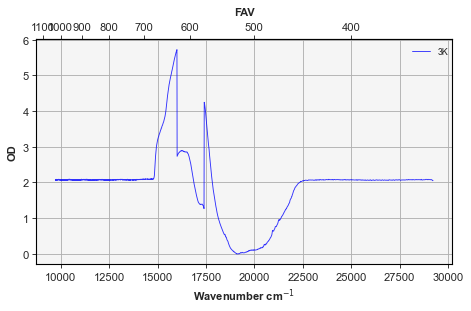

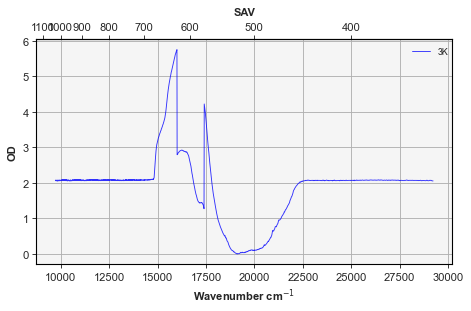

In [6]:
plt.x_label = 'Wavenumber cm$^{-1}$'
plt.y_label = 'OD'

for index, polarisation in enumerate(config_file.polarisations):
    plt.title = polarisation
    plt.plot_spectra(x_data=wavevector_sets[index], y_data=OD_sets[index], shifter=0.05, data_labels=folder_list)

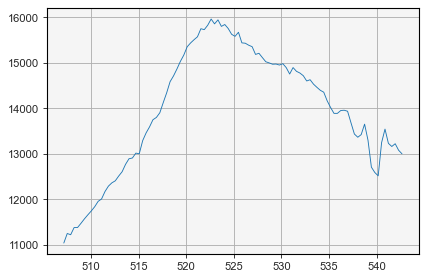

In [17]:
import matplotlib.pyplot as mp
start, stop = 450, 550
mp.plot(spectra_waves[0][0][start:stop], spectra_intensities[0][0][start:stop])